In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
from fredapi import Fred
import quandl

In [3]:
# https://github.com/mortada/fredapi
fred = Fred(api_key="a02df0a22c57860f5f7cf25edc70ffb3")
quandl.ApiConfig.api_key = "QZLZXdHDDPZna9Yw48NP"

### National Analysis

Define the variables to be used in analysis:

X Attributes:
* *Monthly* Stocks
    * S&P 500 (MULTPL/SP500_REAL_PRICE_MONTH)
* *Quarterly* Gross Domestic Product (GDP)
* *Annual* Age Dependency Ratio (SPPOPDPNDOLUSA)
    * Ratio of Older Dependents to Working-Age Population for the United States
* *Monthly* Civilian Noninstitutional Population
    * Population who are not inmates of institutions (penal, mental facilities, homes for the aged), and who are not on active duty in the Armed Forces
        * 20 to 24 years (LNU00000036)
        * 25 to 54 years (LNU00000060)
        * 55 years and over (LNU00024230)
* *Monthly* Unemployment Rate (UNRATE)
* *Quarterly* Homeownership Rate for the United States (RHORUSQ156N)
* *Annual* Home Vacancy Rate for the United States (USHVAC)

y:
* *Monthly* Case-Shiller U.S. National Home Price Index (CSUSHPINSA)

Connect to APIs and create a dataframe with information from each dataset:

In [4]:
def get_info(names):
    data = []
    for i in range(len(names)):
        data.append(fred.get_series(names[i]).to_frame().rename(columns={0:names[i]}))
        data[i] = data[i].groupby(data[i].index.year).mean().dropna()
    return data

In [5]:
sp500 = quandl.get('MULTPL/SP500_REAL_PRICE_MONTH').rename(columns={'Value':'SP500'})
names = ["GDP", "SPPOPDPNDOLUSA", "LNU00000036", "LNU00000060", "LNU00024230", "UNRATE", "RHORUSQ156N", "USHVAC"]
sp500 = sp500.groupby(sp500.index.year).mean().dropna()
us_data_series = get_info(names) + [sp500]

In [6]:
usHPI = fred.get_series('CSUSHPINSA').to_frame().rename(columns={0:'CSUSHPINSA'})
usHPI_annual = usHPI.groupby(usHPI.index.year).mean().dropna()

In [7]:
us_annual = usHPI_annual.copy()
for df in us_data_series:
    us_annual = us_annual.merge(df, left_index=True, right_index=True)
us_annual.tail()

,CSUSHPINSA,GDP,SPPOPDPNDOLUSA,LNU00000036,LNU00000060,LNU00024230,UNRATE,RHORUSQ156N,USHVAC,SP500
2014,164.699833,17527.25825,21.514698,22079.500000,124510.583333,84723.500000,6.158333,64.475,1.9,1930.667500
2015,172.211417,18224.78025,22.141440,21970.916667,125108.666667,87102.333333,5.275000,63.650,1.8,2061.199167
2016,180.984333,18715.04050,22.797998,21720.666667,125760.583333,89342.416667,4.875000,63.400,1.7,2091.844167
2017,191.519250,19519.42350,23.461460,21395.750000,125696.916667,91232.166667,4.350000,63.850,1.6,2448.217500
2018,202.666667,20580.22300,24.139975,21239.166667,126390.000000,93396.666667,3.891667,64.425,1.5,2744.680000


Analyze the correlation coefficient for each indicator we have specified:

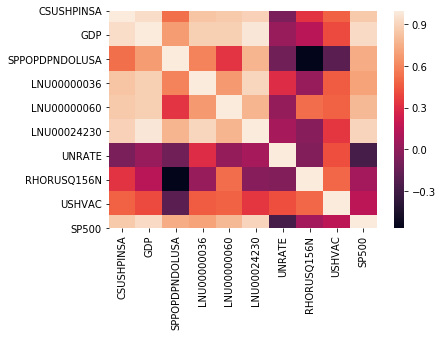

In [8]:
corr = us_annual.corr().round(4)
sns.heatmap(data=corr)

In [9]:
corr

,CSUSHPINSA,GDP,SPPOPDPNDOLUSA,LNU00000036,LNU00000060,LNU00024230,UNRATE,RHORUSQ156N,USHVAC,SP500
CSUSHPINSA,1.0000,0.9406,0.5246,0.8381,0.8647,0.8925,-0.0822,0.3273,0.4852,0.8625
GDP,0.9406,1.0000,0.6828,0.8786,0.8790,0.9803,0.0329,0.1456,0.4091,0.9273
SPPOPDPNDOLUSA,0.5246,0.6828,1.0000,0.5923,0.3385,0.7784,-0.1147,-0.5667,-0.1954,0.7486
LNU00000036,0.8381,0.8786,0.5923,1.0000,0.6701,0.9102,0.3076,0.0230,0.4634,0.7108
LNU00000060,0.8647,0.8790,0.3385,0.6701,1.0000,0.7739,0.0195,0.5224,0.4850,0.7962
LNU00024230,0.8925,0.9803,0.7784,0.9102,0.7739,1.0000,0.0788,-0.0291,0.3401,0.9061
UNRATE,-0.0822,0.0329,-0.1147,0.3076,0.0195,0.0788,1.0000,-0.0467,0.4216,-0.2786
RHORUSQ156N,0.3273,0.1456,-0.5667,0.0230,0.5224,-0.0291,-0.0467,1.0000,0.5031,0.0750
USHVAC,0.4852,0.4091,-0.1954,0.4634,0.4850,0.3401,0.4216,0.5031,1.0000,0.1585
SP500,0.8625,0.9273,0.7486,0.7108,0.7962,0.9061,-0.2786,0.0750,0.1585,1.0000


Create a model using linear regression to express the Case-Schiller index as dependent on the other datasets we have downloaded:

In [10]:
X = us_annual.drop(columns=['CSUSHPINSA'], axis=1)
Y = us_annual['CSUSHPINSA']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('Root Mean Squared Error is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
Root Mean Squared Error is 4.347607380219566
R2 score is 0.9893143554524647


The model performance for testing set
--------------------------------------
Root Mean Squared Error is 10.188044637012396
R2 score is 0.9468582800978659
